In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import boto3, re, json, random, hashlib, math, time, glob
import pandas as pd
import numpy as np
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns
import deferred_acceptance as da
import scripts.setup_data as setup_data
import scripts.experiments as exp

/Users/ElliotKim/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data and necessary variables

In [3]:
df = pd.read_csv('../data/final.csv')
model_key = ['Llama','Mistral', 'Claude', 'Nova','Gpt']
scores_df, with_hand_df = setup_data.filter_and_prepare_data(df)
filtered_columns = [col for col in scores_df.columns if any(key in col for key in model_key)]
C = len(scores_df['Job_index'].unique())
N = len(scores_df['Resume_index'].unique())

resume_dic = {i: idx for i, idx in enumerate(list(scores_df['Resume_index'].unique()))}
job_dic = {i: idx for i, idx in enumerate(list(scores_df['Job_index'].unique()))}

hand_resume_dic = {i: idx for i, idx in enumerate(list(with_hand_df['Resume_index'].unique()))}
hand_job_dic = {i: idx for i, idx in enumerate(list(with_hand_df['Job_index'].unique()))}

firm_models = [col for col in scores_df.columns if 'firm' in col and 'Hand' not in col]
app_models = [col for col in scores_df.columns if 'app' in col and 'Hand' not in col]

/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[col] = pd.to_numeric(scores_df[col], errors="coerce")
/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[cols_to_fill] = scores_df[cols_to_fill].apply(


### Code to generate Figure 3a

In [ ]:
n_df = exp.analyze_num_llm_homogeneity_rate(scores_df, firm_models, filtered_columns)

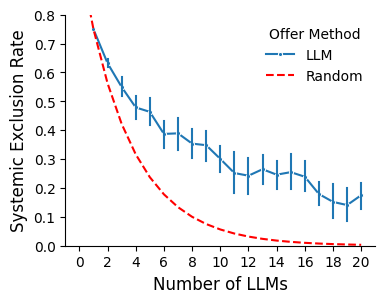

In [ ]:
plt.figure(figsize=(4, 3))
sns.lineplot(
    data=n_df,
    x='num_llms',
    y='fail_rate',
    err_style="bars",
    label="LLM",
    marker="."
)
x_vals = np.arange(0, 21, 1)  # Match range with num_llms
y_vals = 0.75 ** x_vals
plt.plot(x_vals, y_vals, 'r--', label=r'Random')
plt.xlabel('Number of LLMs', fontsize=12)
plt.ylabel('Systemic Exclusion Rate', fontsize=12)
plt.xticks(np.arange(0,21,2))
plt.ylim(0,0.8)
legend = plt.legend(frameon=False, fontsize=10, title="Offer Method")
sns.despine()
plt.savefig("../final_figures/4.5_bedrock_fail_rate_vs_num_llms_combined.pdf",dpi=3000, bbox_inches="tight")
plt.show()

### Code to generate Figure 3b

In [ ]:
experiment_names = ['Firms use Same LLM', 'Firms Same Company LLM', 'Latest', 'RandomLLM', 'RandomPref']
trials = 1500
rows = []
for i in range(trials):
    vals = {}
    start = time.time()
    job = random.randint(0,C-1)
    f_rank_df = exp.generate_llm_firm_pref(exp.add_noise(scores_df, filtered_columns), firm_models)
    # Same LLM 
    rates = 0
    for model in firm_models:
        firm_cols = [f"{model}_j{job}"for _ in range(C)]
        rates += exp.get_sys_excl_rate(f_rank_df, firm_cols)
    vals["Firms use Same LLM"]=(rates/len(firm_models))
    # Same Company
    company_keywords = ['Llama', 'Mistral', 'Nova', 'Claude', 'Gpt']
    company_models = {company: [model for model in firm_models if company in model] for company in company_keywords}
    rates = 0
    for company, models in company_models.items():
        firm_cols = [f"{random.sample(models,1)[0]}_j{job}" for _ in range(C)]
        rates += exp.get_sys_excl_rate(f_rank_df, firm_cols)
    vals['Firms Same Company LLM']=(rates/len(company_keywords))
    # Latest/Biggest Models
    latest_models = ['Llama3-3-70b_firm_rate_comb2', 'Mistral-Large_firm_rate_comb2', 'Nova-Pro_firm_rate_comb2',
                    'Claude_3.5_Sonnet(20241022)_firm_rate_comb2', 'Gpt-4o-mini_firm_rate_comb2']
    firm_cols = [f"{random.sample(latest_models,1)[0]}_j{job}" for _ in range(C)]
    vals["Latest"]=(exp.get_sys_excl_rate(f_rank_df, firm_cols))
    # Random LLM
    sampled_models = random.sample(firm_models, 5)
    firm_cols = [f"{sampled_models[i % 5]}_j{job}" for i in range(C)]
    vals['RandomLLM']=(exp.get_sys_excl_rate(f_rank_df, firm_cols))
    # Random Pref
    random_f_rank_df = exp.generate_random_firm_pref(scores_df, firm_models)
    sampled_cols = random.sample(list(random_f_rank_df.iloc[:,1:].columns), 5)
    firm_cols = [sampled_cols[i % 5] for i in range(C)]
    vals['RandomPref']=(exp.get_sys_excl_rate(random_f_rank_df, firm_cols))
    end = time.time()
    rows.append(vals)
    print(f"Trial {i}: {end-start}")
sys_excl_df = pd.DataFrame(rows)

/var/folders/r1/pqhz0v150tndhtgcdhn55v1m0000gn/T/ipykernel_55984/4139667590.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(frameon=False, fontsize=10)


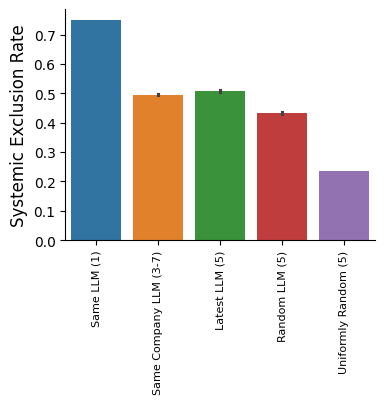

In [ ]:
plot_experiment_names = ['Same LLM (1)', 'Same Company LLM (3-7)', 'Latest LLM (5)', 'Random LLM (5)', 'Uniformly Random (5)']
plt.figure(figsize=(4,3))
sns.barplot(
    data=sys_excl_df,  
    errorbar="se",
)
plt.ylabel("Systemic Exclusion Rate", fontsize=12)
plt.xticks(
    ticks=range(len(experiment_names)),  # Match the number of bars
    labels=plot_experiment_names,
    fontsize=8,
    rotation=90
)
sns.despine()
legend = plt.legend(frameon=False, fontsize=10)
plt.savefig(f'../final_figures/4.5_sys_excl_rate.pdf', dpi=3000, bbox_inches="tight")
plt.show()